In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Initializing model...
Loading MNIST dataset...
Train samples: 60000, Test samples: 10000

Visualizing sample images...


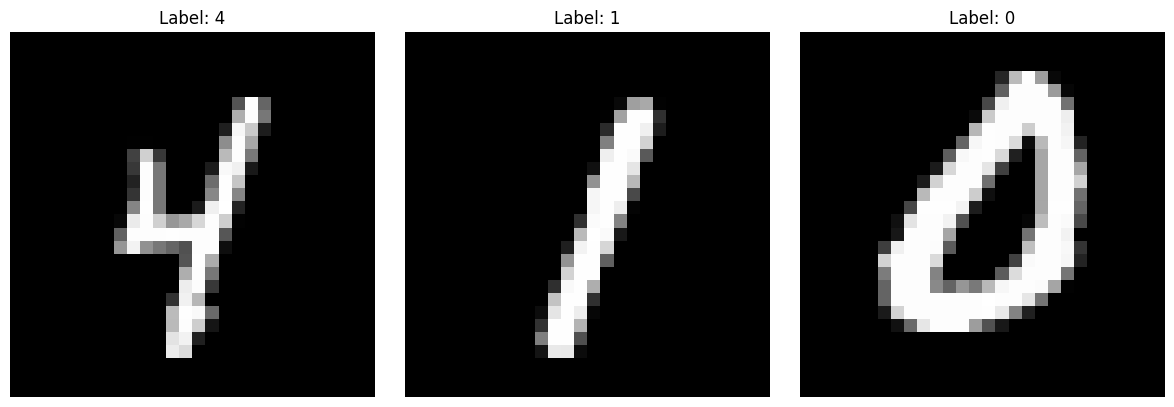


Training for 5 epochs...


Epoch 1/5: 100%|██████████| 469/469 [00:12<00:00, 37.64it/s] 


Epoch 1: Train Loss=0.3566, Train Acc=0.9118, Test Loss=0.0716, Test Acc=0.9802


Epoch 2/5: 100%|██████████| 469/469 [00:02<00:00, 211.78it/s]


Epoch 2: Train Loss=0.0614, Train Acc=0.9835, Test Loss=0.0465, Test Acc=0.9856


Epoch 3/5: 100%|██████████| 469/469 [00:02<00:00, 216.49it/s]


Epoch 3: Train Loss=0.0415, Train Acc=0.9885, Test Loss=0.0405, Test Acc=0.9866


Epoch 4/5: 100%|██████████| 469/469 [00:02<00:00, 170.55it/s]


Epoch 4: Train Loss=0.0314, Train Acc=0.9916, Test Loss=0.0365, Test Acc=0.9880


Epoch 5/5: 100%|██████████| 469/469 [00:02<00:00, 209.62it/s]


Epoch 5: Train Loss=0.0249, Train Acc=0.9936, Test Loss=0.0322, Test Acc=0.9896

LAYER PROBING DEMONSTRATION

Probing all layers...
stem: shape = (1, 28, 28, 16)
block1: shape = (1, 28, 28, 16)
block2: shape = (1, 14, 14, 32)
block3: shape = (1, 7, 7, 64)
fc: shape = (1, 10)

Probing specific layers [1, 3]...
block1: shape = (1, 28, 28, 16)
block3: shape = (1, 7, 7, 64)

Accessing layers by index...
Layer 0 (stem): Conv
Layer 1 (block1): ResidualBlock
Layer 2 (block2): ResidualBlock
Layer 3 (block3): ResidualBlock
Layer 4 (fc): Linear

Training complete! Model is ready for EKF fine-tuning on CIFAR.


In [37]:
# ---------- Imports ----------
import jax
import jax.numpy as jnp
from flax import nnx
import optax
import tensorflow_datasets as tfds
from tqdm import tqdm
import matplotlib.pyplot as plt
from typing import List

# ---------- Define Residual Block ----------
class ResidualBlock(nnx.Module):
    def __init__(self, in_channels: int, out_channels: int, stride: int = 1, rngs: nnx.Rngs = None):
        self.conv1 = nnx.Conv(
            in_features=in_channels, 
            out_features=out_channels,
            kernel_size=(3, 3), 
            strides=(stride, stride),
            padding="SAME", 
            rngs=rngs
        )
        self.bn1 = nnx.BatchNorm(num_features=out_channels, rngs=rngs)
        
        self.conv2 = nnx.Conv(
            in_features=out_channels, 
            out_features=out_channels,
            kernel_size=(3, 3), 
            strides=(1, 1),
            padding="SAME", 
            rngs=rngs
        )
        self.bn2 = nnx.BatchNorm(num_features=out_channels, rngs=rngs)
        
        # Shortcut connection
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nnx.Conv(
                in_features=in_channels, 
                out_features=out_channels,
                kernel_size=(1, 1), 
                strides=(stride, stride),
                padding="SAME", 
                rngs=rngs
            )
            self.has_projection = True
        else:
            self.has_projection = False
    
    def __call__(self, x):
        identity = self.shortcut(x) if self.has_projection else x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = nnx.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        out = out + identity
        out = nnx.relu(out)
        
        return out

# ---------- Define Small ResNet with Indexable Layers ----------
class ResNetSmall(nnx.Module):
    def __init__(self, num_classes: int = 10, rngs: nnx.Rngs = None):
        # Layer 0: Stem
        self.stem = nnx.Conv(
            in_features=1, 
            out_features=16, 
            kernel_size=(3, 3),
            padding="SAME", 
            rngs=rngs
        )
        self.stem_bn = nnx.BatchNorm(num_features=16, rngs=rngs)
        
        # Layers 1-3: Residual blocks
        self.block1 = ResidualBlock(16, 16, stride=1, rngs=rngs)
        self.block2 = ResidualBlock(16, 32, stride=2, rngs=rngs)
        self.block3 = ResidualBlock(32, 64, stride=2, rngs=rngs)
        
        # Layer 4: Classifier
        self.fc = nnx.Linear(in_features=64, out_features=num_classes, rngs=rngs)
        
        # Store layer names for probing
        self.layer_names = ['stem', 'block1', 'block2', 'block3', 'fc']
    
    def __call__(self, x, return_intermediates: bool = False):
        intermediates = {}
        
        # Layer 0: Stem
        x = self.stem(x)
        x = self.stem_bn(x)
        x = nnx.relu(x)
        if return_intermediates:
            intermediates['stem'] = x
        
        # Layer 1: Block 1
        x = self.block1(x)
        if return_intermediates:
            intermediates['block1'] = x
        
        # Layer 2: Block 2
        x = self.block2(x)
        if return_intermediates:
            intermediates['block2'] = x
        
        # Layer 3: Block 3
        x = self.block3(x)
        if return_intermediates:
            intermediates['block3'] = x
        
        # Global average pooling
        x = jnp.mean(x, axis=(1, 2))
        
        # Layer 4: Classifier
        x = self.fc(x)
        if return_intermediates:
            intermediates['fc'] = x
        
        if return_intermediates:
            return x, intermediates
        return x
    
    def get_layer(self, layer_idx: int):
        """Get layer by index for probing"""
        layers = [self.stem, self.block1, self.block2, self.block3, self.fc]
        if 0 <= layer_idx < len(layers):
            return layers[layer_idx]
        raise IndexError(f"Layer index {layer_idx} out of range [0, {len(layers)-1}]")

# ---------- Load MNIST ----------
def load_mnist(batch_size: int = 128):
    ds_builder = tfds.builder("mnist")
    ds_builder.download_and_prepare()
    train_ds = ds_builder.as_dataset(split="train", as_supervised=True)
    test_ds = ds_builder.as_dataset(split="test", as_supervised=True)
    
    def preprocess(image, label):
        image = jnp.array(image, dtype=jnp.float32) / 255.0
        label = jnp.array(label, dtype=jnp.int32)
        return image, label
    
    train_data = [(preprocess(img, lbl)) for img, lbl in tfds.as_numpy(train_ds)]
    test_data = [(preprocess(img, lbl)) for img, lbl in tfds.as_numpy(test_ds)]
    
    return train_data, test_data

# ---------- Batching Function ----------
def create_batches(data, batch_size: int):
    """Create batches from data"""
    batches = []
    for i in range(0, len(data), batch_size):
        batch = data[i:i + batch_size]
        images = jnp.stack([img for img, _ in batch])
        labels = jnp.array([lbl for _, lbl in batch])
        batches.append((images, labels))
    return batches

# ---------- Training Functions ----------
@nnx.jit
def train_step(model, optimizer, x, y):
    """Single training step"""
    def loss_fn(model):
        logits = model(x)
        loss = optax.softmax_cross_entropy_with_integer_labels(logits, y).mean()
        return loss, logits
    
    grad_fn = nnx.value_and_grad(loss_fn, has_aux=True)
    (loss, logits), grads = grad_fn(model)
    optimizer.update(grads)
    
    acc = jnp.mean(jnp.argmax(logits, axis=-1) == y)
    return loss, acc

@nnx.jit
def eval_step(model, x, y):
    """Single evaluation step"""
    logits = model(x)
    loss = optax.softmax_cross_entropy_with_integer_labels(logits, y).mean()
    acc = jnp.mean(jnp.argmax(logits, axis=-1) == y)
    return loss, acc

# ---------- Probing Function ----------
def probe_layers(model, x, layer_indices: List[int] = None):
    """
    Probe intermediate layer activations
    
    Args:
        model: The ResNet model
        x: Input batch
        layer_indices: List of layer indices to probe (None = all layers)
    
    Returns:
        Dictionary mapping layer names to their activations
    """
    logits, intermediates = model(x, return_intermediates=True)
    
    if layer_indices is not None:
        filtered = {}
        for idx in layer_indices:
            if 0 <= idx < len(model.layer_names):
                name = model.layer_names[idx]
                filtered[name] = intermediates[name]
        return filtered
    
    return intermediates

# ---------- Main Training Loop ----------
def main():
    # Initialize model
    print("Initializing model...")
    rngs = nnx.Rngs(0)
    model = ResNetSmall(num_classes=10, rngs=rngs)
    
    # Initialize optimizer
    optimizer = nnx.Optimizer(model, optax.adam(1e-3))
    
    # Load data
    print("Loading MNIST dataset...")
    train_data, test_data = load_mnist()
    print(f"Train samples: {len(train_data)}, Test samples: {len(test_data)}")
    
    # Visualize samples
    print("\nVisualizing sample images...")
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    for i in range(3):
        img, label = train_data[i]
        axes[i].imshow(img.squeeze(), cmap="gray")
        axes[i].set_title(f"Label: {int(label)}")
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()
    
    # Create batches
    batch_size = 128
    train_batches = create_batches(train_data, batch_size)
    test_batches = create_batches(test_data, batch_size)
    
    # Training loop
    num_epochs = 5
    print(f"\nTraining for {num_epochs} epochs...")
    
    for epoch in range(num_epochs):
        # Training
        train_loss_sum = 0.0
        train_acc_sum = 0.0
        
        for x_batch, y_batch in tqdm(train_batches, desc=f"Epoch {epoch+1}/{num_epochs}"):
            loss, acc = train_step(model, optimizer, x_batch, y_batch)
            train_loss_sum += loss
            train_acc_sum += acc
        
        train_loss = train_loss_sum / len(train_batches)
        train_acc = train_acc_sum / len(train_batches)
        
        # Evaluation
        test_loss_sum = 0.0
        test_acc_sum = 0.0
        
        for x_batch, y_batch in test_batches:
            loss, acc = eval_step(model, x_batch, y_batch)
            test_loss_sum += loss
            test_acc_sum += acc
        
        test_loss = test_loss_sum / len(test_batches)
        test_acc = test_acc_sum / len(test_batches)
        
        print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, "
              f"Test Loss={test_loss:.4f}, Test Acc={test_acc:.4f}")
    
    # ---------- Layer Probing Demo ----------
    print("\n" + "="*50)
    print("LAYER PROBING DEMONSTRATION")
    print("="*50)
    
    # Get a sample batch
    sample_x, sample_y = test_batches[0]
    sample_x_single = sample_x[:1]  # Single image
    
    # Probe all layers
    print("\nProbing all layers...")
    all_activations = probe_layers(model, sample_x_single)
    
    for layer_name, activation in all_activations.items():
        print(f"{layer_name}: shape = {activation.shape}")
    
    # Probe specific layers
    print("\nProbing specific layers [1, 3]...")
    specific_activations = probe_layers(model, sample_x_single, layer_indices=[1, 3])
    
    for layer_name, activation in specific_activations.items():
        print(f"{layer_name}: shape = {activation.shape}")
    
    # Access layers by index
    print("\nAccessing layers by index...")
    for i in range(len(model.layer_names)):
        layer = model.get_layer(i)
        print(f"Layer {i} ({model.layer_names[i]}): {type(layer).__name__}")
    
    return model, optimizer

if __name__ == "__main__":
    model, optimizer = main()
    print("\nTraining complete! Model is ready for EKF fine-tuning on CIFAR.")